## Thermal subduction, linear rheology:


The viscous rheology in this model is similar to the models described in the PhD thesis of Micheal Kaplan



**Keywords:** subduction, thermally-activated creep, 


**References:**


Kaplan, Michael. Numerical Geodynamics of Solid Planetary Deformation. Diss. University of Southern California, 2015.

In [297]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

Model name and directories
-----

In [298]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [299]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [300]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/Base/checkpoint/ is empty
results/T/0/Base/checkpoint/10 has files
results/T/0/Base/checkpoint/15 has files
results/T/0/Base/checkpoint/20 has files
results/T/0/Base/checkpoint/5 has files


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [301]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

In [302]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Set parameter dictionaries**

In [303]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


#Style => parameters_like_this

dp = edict({'LS':670*1e3, #Scaling Length scale
            'depth':670*1e3, #Depth of domain
           'rho':3300.,  #reference density
           'g':9.8, #surface gravity
           'eta0':1.2e20, #
           'k':1e-6, #thermal diffusivity
           'a':3e-5, #surface thermal expansivity
           'TP':1673., #mantle potential temp (K)
           'TS':273., #surface temp (K)
           'cohesion':40e6, #cohesion in scalar yield function
           'fc':0.03,   #friction coefficient in yield function(tan(phi))
           'Adf':3e-11, #pre-exp factor for diffusion creep
           'Edf':1e5,
           #'Vdf':4e-6,
           #'Elm':2.0e5,
           #'Vlm':1.1e-6,
           #'SR':1e-15,
           #'rDepth':250e3, #reference depth (used to scale / normalize the flow laws)
           'R':8.314, #gas constant
           #'Cp':1250., #Specific heat (Jkg-1K-1)
           'StALS':100e3, #depth of sticky air layer
           'plate_vel':4})

#Adiabatic heating stuff
#dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
#dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.deltaT = dp.TP - dp.TS
#dp.rTemp= dp.TP + dp.rDepth*dp.dTa #reference temp, (potential temp + adiabat)


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) , 
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            #'W':(-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
            #'E': 1./(dp.R*dp.deltaT), #using deltaTa, the guesstimated adiabatic temp differnnce to scale these paramters
            #'Ads':(dp.eta0**(ndp.n-2))*((dp.k)**(ndp.n-1))*((dp.LS)**(2. - 2*ndp.n))       
           })

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*(dp.TP - dp.TS)*(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaT),
            #'Wdf':dp.Vdf*sf.W,
            'Edf':math.log(dp.Edf),
            #'Wps':dp.Vpr*sf.W,
            #'Eps':dp.Epr*sf.E,
            #'Wds':dp.Vds*sf.W,
            #'Eds':dp.Eds*sf.E,
            #'Elm':dp.Elm*sf.E,
            #'Elm':dp.Elm*sf.E,
            #'Wlm':dp.Vlm*sf.W,
            'TSP':0., 
            'TBP':1.,
            'TPP':(dp.TP - dp.TS)/dp.deltaT, #dimensionless potential temp
            #'rDepth':dp.rDepth/dp.LS,
            #'rTemp':(dp.rTemp- dp.TS)/dp.deltaT,
            #'n':3.5, #Dislocation creep stress exponent
            'np':20., #Peierls creep stress exponent
            'TS':dp.TS/dp.deltaT,
            'TP':dp.TP/dp.deltaT,
            'eta_min':1e-3, 
            'eta_max':1e5, #viscosity max in the mantle material
            #'eta_min_crust':1e-3, #crust viscosity, if using isoviscous weak crust
            'eta_max_crust':1., #viscosity max in the weak-crust material
            #'H':0.,
            #'Tmvp':0.6,
            #'Di': dp.a*dp.g*dp.LS/dp.Cp, #Dissipation number
            'Steta0':5e-2,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
            'low_mantle_visc_fac':10.,
            'crust_cohesion_fac':0.1,
            'crust_fc_fac':0.1
            })



#Make some further additions to paramter dictionaries

#dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity from a scaling relationship
#dp.SR = dp.VR/dp.LS #characteristic strain rate
#ndp.VR = dp.VR*sf.vel #characteristic velocity
#ndp.SR = dp.SR*sf.SR #characteristic strain rate


#ndp.SR = dp.SR*sf.SR #characteristic strain rate

ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
#ndp.TaP = 1. - ndp.TPP,  #Dimensionles adiabtic component of delta t

In [304]:
t1 = 2918002.6260000006
ndp.fcd

2431668.8550000004

In [305]:
#40000./sf.vel, 
ndp.RA
#ndp.plate_vel
#ndp.Edf
#3404336.

3404336.397000001

In [306]:
#(4.0065172577e-06*sf.SR)/(3600.*24*365)

In [307]:
dp.CVR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.))
ndp.CVR = dp.CVR*sf.vel #characteristic velocity
ndp.CVR, ndp.plate_vel, ndp.RA , (dp.TP - dp.TS)


(2263.019582399744, 849.2588923739356, 3404336.397000001, 1400.0)

In [308]:
###########
#lengths scales for various processes (material transistions etc.)
###########

MANTLETOCRUST = (10.*1e3)/dp.LS #Crust depth
HARZBURGDEPTH = MANTLETOCRUST + (27.7e3/dp.LS)
CRUSTTOMANTLE = (800.*1e3)/dp.LS
LITHTOMANTLE = (900.*1e3)/dp.LS
MANTLETOLITH = (200.*1e3)/dp.LS
TOPOHEIGHT = (10.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
#AVGTEMP = ndp.TPP #Used to define lithosphere
LOWMANTLEDEPTH = (660.*1e3)/dp.LS 
CRUSTVISCUTOFF = (100.*1e3)/dp.LS #Deeper than this, crust material rheology reverts to mantle rheology
AGETRACKDEPTH = 100e3/dp.LS #above this depth we track the age of the lithsphere (below age is assumed zero)


In [309]:
#MINX

**Model setup parameters**

In [310]:
###########
#Model setup parameters
###########

#Modelling and Physics switches
refineMesh = True
stickyAir = False
meltViscosityReduction = False
symmetricIC = False
VelBC = False
aspectRatio = 4
compBuoyancy = False #use compositional & phase buoyancy, or simply thermal
viscMechs = ['diffusion', 'dislocation', 'peierls', 'yielding']
viscCombine = 'harmonic' #'harmonic', 'min', 'mixed'....

#Domain and Mesh paramters
dim = 2          # number of spatial dimensions

tot_depth = np.round(dp.depth/dp.LS, 3)

#These options allow us to explore the choice of different length scalings

if tot_depth == 1.: #Depth equal to length scale
    MINY = 0.
    MAXY = 1.
elif tot_depth > 1.: #Depth larger than to length scale
    MINY = 0.
    MAXY = tot_depth
    
elif tot_depth < 1.: #Depth smaller to length scale
    MINY = np.round(1. - tot_depth, 2)
    MAXY = 1.
    
MINX = np.round(-1.*tot_depth*aspectRatio/2., 2)  #Aspect ratio is fixed, x-domain shifts according to system depth and length scale

MAXX = np.round(1.*tot_depth*aspectRatio/2., 2)

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
RES = 96
Xres = int(RES*aspectRatio)
#if MINY == 0.5:
#    Xres = int(2.*RES*aspectRatio)
    

if stickyAir:
    Yres = RES
    MAXY = np.round(MAXY + dp.StALS/dp.LS, 2)
    
else:
    Yres = RES
    MAXY = np.round(MAXY, 2)

periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff
PIC_integration=True
ppc = 25

#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 10, 10
gldbs_output = 10
checkpoint_every, files_output = 5, 10
metric_output = 5
sticky_air_temp = 5

In [311]:
MINY, MAXY

(0.0, 1.0)

In [312]:
MINY, MAXY,MINX, MAXX, tot_depth

(0.0, 1.0, -2.0, 2.0, 1.0)

Create mesh and finite element variables
------

In [313]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [314]:
mesh.reset()

In [315]:
###########
#Mesh refinement
###########

#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(384, 0.0052093750000000369, 3.0003999999999929, 0.99960000000002847)
('edges', 384)
-- iteration 0 --
| F( p_n ) |^2: 5.47966873056e-05
| p_n+1 - p_n |^2: 12.7983513831
-- iteration 1 --
| F( p_n ) |^2: 5.75247890072e-30
Min, Max element width: 
0.00521
0.01562


In [316]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = MAXY #nodes will remain along this line


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [317]:
###########
#Mesh refinement
###########

if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(96, 0.0052093750000000742, 0.74749583333333336, 1.0206484210526607)
('edges', 96)
-- iteration 0 --
| F( p_n ) |^2: 5.53734945404e-05
| p_n+1 - p_n |^2: 0.816603998686
-- iteration 1 --
| F( p_n ) |^2: 6.02479034853e-31
Min, Max element width: 
0.00521
0.01562


In [318]:
#fig= glucifer.Figure()

#fig.append(glucifer.objects.Mesh(mesh))

#fig.show()
#fig.save_database('test.gldb')

In [319]:
#THis is a hack for adding a sticky air domain, we refine MAXY and things like the temperature stencil work from Y = 1. 

if stickyAir:
    MAXY = 1.

Initial conditions
-------


In [320]:
coordinate = fn.input()
depthFn = MAXY - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate

#potTempFn = ndp.TPP + (depthFn)*ndp.TaP #a function providing the adiabatic temp at any depth
#abHeatFn = -1.*velocityField[1]*temperatureField*ndp.Di #a function providing the adiabatic heating rate

###########
#Thermal initial condition:
#if symmetricIC, we build a symmetric downwelling on top of a sinusoidal perturbation
##########

#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
iD = 1000e3/dp.LS #Initial Slab depth
dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS #Boundary layer/slab initial condition
delX1 = fn.misc.min(fn.math.abs(coordinate[0] - -0.), fn.math.abs(coordinate[0] - -2.))
delX = fn.misc.min(delX1 , fn.math.abs(coordinate[0] - 2.))
w = w0*fn.math.sqrt(delX + 1e-7)
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP
delX = fn.misc.min(fn.math.abs(coordinate[0] - - 1.) , fn.math.abs(coordinate[0] - 1.))
tempSlab = (potTempFn ) *fn.math.erf((delX*2.)/w0) + ndp.TSP       
tempFn1 =  fn.misc.min(tempBL, tempSlab)
blFn = fn.branching.conditional([(depthFn < iD, tempFn1), 
                                    (True, potTempFn)])

tempFn = 0.*sinFn + 1.*blFn #partition the temp between these the symmetric downwelling and sinusoid
if symmetricIC:  
    if not checkpointLoad:
        temperatureField.data[:] = tempFn.evaluate(mesh)  

In [321]:

def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX
    r_grad =  1./(abs(rMOR-sz))
    l_grad =  1./(abs(sz-lMOR))
    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, r_grad*opFac*(xFn -abs(rMOR)) / (abs(MAXX-rMOR))),
                                      (True, l_grad*fn.math.abs((((xFn + abs(lMOR)) / (abs(lMOR - MINX))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [247]:
###########
#Thermal initial condition 2: 
#if symmetricIC == False, we build an asymmetric subduction-zone
###########




#Main control paramters are:


Roc = 250e3 #radius of curvature of slab
theta = 70. #Angle to truncate the slab (can also do with with a cutoff depth)
subzone = 0.0 #X position of subduction zone...in model coordinates
slabmaxAge = 75e6 #age of subduction plate at trench
platemaxAge = 75e6 #max age of slab (Plate model)
ageAtTrenchSeconds = min(platemaxAge*(3600*24*365), slabmaxAge*(3600*24*365))
lRidge = -0.5*(670e3*4)/dp.LS  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
rRidge = 0.5*(670e3*4)/dp.LS

sense = 'Right' #dip direction
op_age_fac = 0.2 #this controls the overidding plate age reduction


#First build the top TBL
#Create functions between zero and one, to control age distribution






#ageFn1 = fn.misc.max(0., 1. - fn.math.abs(xFn/MAXX))

#ageFn  = fn.branching.conditional([(coordinate[0] <= 0, ageFn1),
 #                                 (True, ageFn1/op_age_fac)])
    
    


#ageFn = age_fn(xFn, sz = -0.5, lMOR=-2., rMOR=2.)
ageFn = age_fn(xFn, sz =subzone, lMOR=lRidge,rMOR=rRidge, conjugate_plate=True, opFac = op_age_fac)

#dimensionlize the age function
ageFn *= slabmaxAge*(3600*24*365)
#ageFn = fn.misc.min(ageFn, platemaxAge*(3600*24*365)) #apply plate model

w0 = (2.*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (ndp.TP - ndp.TS) *fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function

tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, ndp.TPP)])

if not symmetricIC:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()





In [248]:
#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2



#Setup slab perturbation params (mostly dimensionlesl / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)
CrustM = MANTLETOCRUST
Org = (subzone, MAXY-RocM)
maxDepth = 250e3/dp.LS

#We use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , RocM)
Ic = inCircleFnGenerator(Org , RocM - w0)
Cc = inCircleFnGenerator(Org , RocM - (1.2*CrustM)) #... weak zone on 'outside' of slab
Hc = inCircleFnGenerator(Org , RocM - HARZBURGDEPTH) #... Harzburgite layer 
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left':
    ptx = subzone - dx
else:
    ptx = subzone + dx
coords = ((0.+subzone, MAXY), (0.+subzone, MAXY-RocM), (ptx, MAXY))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation - could probably avoid particle walk here
if not symmetricIC:
    if not checkpointLoad:
        sdFn = ((RocM - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (MAXY - maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]


In [249]:
sdFn = ((RocM - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
sdFn, slabFn

(<underworld.function._function.multiply at 0x7f82f74adc10>,
 <underworld.function._function.add at 0x7f82f74b7b90>)

In [250]:
#Make sure material in sticky air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= MAXY:
                temperatureField.data[index] = ndp.TSP

In [251]:
#fn.math.erf((sdFn*dp.LS)/(2.*fn.math.sqrt(dp.k*(slabmaxAge*(3600*24*365))))) 
CRUSTVISCUTOFF, MANTLETOCRUST*3

(0.14925373134328357, 0.06716417910447761)

def matplot_field(temperatureField, dp):
    if uw.nProcs() != 1:
        print("only in Serial folks")
    else:
        import matplotlib.pyplot as pyplt
        try :
            if(__IPYTHON__) :
                get_ipython().magic(u'matplotlib inline')
        except NameError :
            pass
        field_data = temperatureField.data.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
        fig, ax = pyplt.subplots(figsize=(32,2))
        ql = dp.LS/1e3
        pyplt.ioff()
        cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
        fig.colorbar(cax, orientation='horizontal' )
        #ax.set_x([0,dp.LS*aspectRatio])
        pyplt.tight_layout()
        
        return fig, ax
        
fig, ax = matplot_field(temperatureField, dp)
fig.savefig('test.png')       

In [252]:
temperatureField.data.min(), temperatureField.data.max()

(0.0, 1.0)

In [253]:

#ageFn = age_fn(xFn)

In [254]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Surface(mesh,temperatureField ))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()

##fig.save_database('test.gldb')
#fig.save_image('test.png')


Boundary conditions
-------

In [255]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]

VelBCs = mesh.specialSets["Empty"]



if VelBC:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (subzone - 0.05*aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (subzone + 0.05*aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if VelBC:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )






if periodic[0] == True:
    if VelBC:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [256]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Swarm setup
-----


In [257]:
###########
#Material Swarm and variables
###########

#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
#tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
ageVariable = gSwarm.add_variable( dataType="double", count=1 )
#testVariable = gSwarm.add_variable( dataType="float", count=1 )


#these lists  are part of the checkpointing implementation
varlist = [materialVariable, yieldingCheck, ageVariable]
varnames = ['materialVariable', 'yieldingCheck', 'ageVariable']

In [258]:
mantleIndex = 0
crustIndex = 1
harzIndex = 2
airIndex = 3



if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    materialVariable.data[:] = mantleIndex
    #tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    ageVariable.data[:] = -1

    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

###########
#This block sets up a checkboard layout of passive tracers
###########

square_size = 0.1
xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [259]:
##############
#Set the initial particle age for particles above the critical depth; 
#only material older than crustageCond will be transformed to crust / harzburgite
##############

ageVariable.data[:] = 0. #start with all zero
ageVariable.data[:] = ageFn.evaluate(gSwarm)/sf.SR
crustageCond = 2e6*(3600.*365.*24.)/sf.SR #set inital age above critical depth. (x...Ma)



ageConditions = [ (depthFn < AGETRACKDEPTH, ageVariable),  #In the main loop we add ageVariable + dt here
                  (True, 0.) ]
                 
#apply conditional 
ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)

ageDT = 0.#this is used in the main loop for short term time increments

In [260]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))


#fig.show()

In [269]:
##############
#Here we set up a directed graph object that we we use to control the transformation from one material type to another
##############

#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#Need a list of all material indexes (safer in parallel)
material_list = [0,1,2,3]

if not checkpointLoad:
    materialVariable.data[:] = 0 #Initialize to zero 

#Setup the graph object
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#Now set the conditions for transformations

hs = 2e3/dp.LS  #add some hysteresis to the depths of transition

#... to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE + hs)
DG.add_transition((harzIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE + hs)
DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, TOPOHEIGHT + hs)

#... to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, subzone + 4.*MANTLETOCRUST) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)


DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((harzIndex,crustIndex), xFn, operator.lt, subzone + 4.*MANTLETOCRUST) #This one sets no crust on the upper plate
DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)

#... to Harzbugite
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.lt, HARZBURGDEPTH)
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.gt, MANTLETOCRUST)
DG.add_transition((mantleIndex,harzIndex), ageVariable, operator.gt, crustageCond) #Note we can mix functions and swarm variabls



#... to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0.)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. )
DG.add_transition((harzIndex,airIndex), depthFn, operator.lt, 0. )


In [270]:
CRUSTTOMANTLE, HARZBURGDEPTH, 0. + 7.*MANTLETOCRUST

(1.1940298507462686, 0.06373134328358208, 0.15671641791044774)

In [271]:
#gSwarm.particleCoordinates.data[particleID][1]

In [272]:
##############
#For the slab_IC, we'll also add a crustal weak zone following the dipping perturbation
##############

if checkpointLoad != True:
    if not symmetricIC:
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            if gSwarm.particleCoordinates.data[particleID][1] < 0.:
                materialVariable.data[particleID] = airIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - maxDepth) and
                Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = crustIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - maxDepth) and
                Hc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = harzIndex

In [273]:
##############
#This is how we use the material graph object to test / apply material transformations
##############
DG.build_condition_list(materialVariable)

for i in range(2): #Need to go through a number of times
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [274]:
#maxDepth


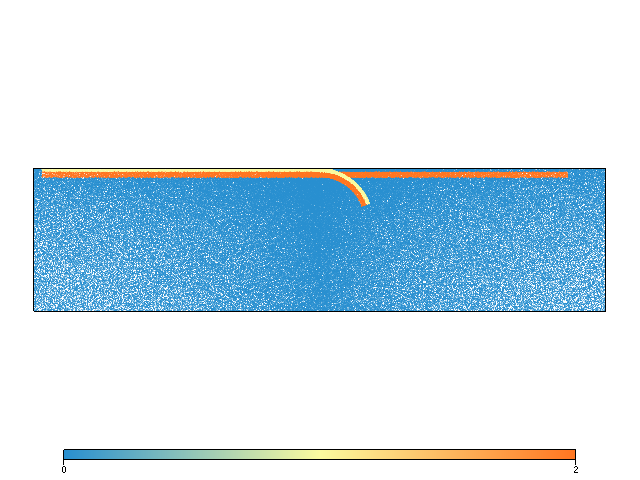

In [275]:
fig2= glucifer.Figure()
fig2.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig2.append( glucifer.objects.Surface(mesh, depthFn))

#fig2.show()
#fig2.save_database('test.gldb')

## phase and compositional buoyancy

This was designed for EBA models, needs a rethink for Boussinesq

In [276]:
##############
#Set up phase buoyancy contributions
#the phase function approach of Yuen and Christenson is implemented in the Slippy2 phase_function class 
##############


#olivine
olivinePhase = phase_function.component_phases(name = 'ol', 
                        depths=[410e3,660e3], #depths of phase transitions along adiabat
                        temps = [1600., 1900.], #temperatures of phase transitions along adiabat
                        widths = [20e3, 20e3], #width if transition
                        claps=[2.e6, -2.5e6],  #Clapeyron slope of trnasition
                        densities = [180., 400.]) #density change of phase transition

olivinePhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaT)


rp = olivinePhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   olivinePhase.ndp['depths'][0],
                                   olivinePhase.ndp['claps'][0],
                                   olivinePhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

olivine_phase_buoyancy = olivinePhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

#garnet
garnetPhase = phase_function.component_phases(name = 'grt', 
                        depths=[60e3,400e3, 720e3],
                        temps = [1000., 1600., 1900.], 
                        widths = [20e3, 20e3, 20e3], 
                        claps=[0.e6, 1.e6, 1.e6], 
                        densities = [350., 150., 400.])

garnetPhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaT)


rp = garnetPhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   garnetPhase.ndp['depths'][0],
                                   garnetPhase.ndp['claps'][0],
                                   garnetPhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

garnet_phase_buoyancy = garnetPhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

In [277]:
##############
#Set up compositional buoyancy contributions
##############

bouyancy_factor = (dp.g*dp.LS**3)/(dp.eta0*dp.k)

basalt_comp_buoyancy  = (dp.rho - 2940.)*bouyancy_factor
harz_comp_buoyancy = (dp.rho - 3235.)*bouyancy_factor
pyrolite_comp_buoyancy = (dp.rho - 3300.)*bouyancy_factor

#print(basalt_comp_buoyancy, harz_comp_buoyancy, pyrolite_comp_buoyancy)


#this function accounts for the decrease in expansivity, and acts to reduce the rayleigh number with depth
alphaRatio = 1.2/3
taFn = 1. - (depthFn)*(1. - alphaRatio) 


if not compBuoyancy:
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn)
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) 
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn)

else : 
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn) -\
                          (0.6*olivine_phase_buoyancy + 0.4*garnet_phase_buoyancy) +\
                           pyrolite_comp_buoyancy
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) -\
                          (0.8*olivine_phase_buoyancy + 0.2*garnet_phase_buoyancy) +\
                           harz_comp_buoyancy
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn) -\
                          (1.*garnet_phase_buoyancy) +\
                           basalt_comp_buoyancy

Rheology
-----



In [278]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [279]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [280]:
ndp.crust_cohesion_fac

0.1

In [281]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############

omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


##Diffusion Creep

diffusion = fn.misc.min(ndp.eta_max, fn.math.exp(-1*ndp.Edf + ndp.Edf / (temperatureField + 1e-8)))



##Define the Plasticity
ys =  ndp.cohesion + (depthFn*ndp.fcd)
ysMax = 10e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = ysf/(2.*(strainRate_2ndInvariant))

##Crust rheology
#crustys =  ndp.cohesion*ndp.crust_cohesion_fac + (depthFn*ndp.fcd*ndp.crust_fc_fac)
crustys =  ndp.cohesion*ndp.crust_cohesion_fac + (ndp.crust_fc_fac*depthFn*ndp.fcd) #only weakened cohesion is discussed, not fc

crustyielding = crustys/(2.*(strainRate_2ndInvariant)) #extra factor to account for underworld second invariant form




In [282]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############

#linear rheology 
linearviscosityFn = safe_visc(diffusion)




#combined rheology    


finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, safe_visc(fn.misc.min(diffusion, yielding))),
                                  (True, safe_visc(safe_visc(diffusion*ndp.low_mantle_visc_fac)))])

#crust rheology    
finalcrustviscosityFn = safe_visc(fn.misc.min(ndp.eta_max_crust, 
                                              crustyielding)) #cohesion weakening factor also applies to eta_0



In [283]:
#.low_mantle_visc_fac

In [284]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,finalviscosityFn, logScale=True))
#fig.append( glucifer.objects.Surface(mesh,finalviscosityFn, logScale=True))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.05))


#fig.show()
#fig.save_database('test.gldb')

Stokes system setup
-----


In [285]:
densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA,
                                    crustIndex:basaltbuoyancyFn, 
                                    mantleIndex:pyrolitebuoyancyFn,
                                    harzIndex:harzbuoyancyFn} )

In [286]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [287]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearviscosityFn, 
                              fn_bodyforce=buoyancyFn )

In [288]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

In [289]:


viscosityMapFn1 = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:finalcrustviscosityFn,
                                    mantleIndex:finalviscosityFn,
                                    harzIndex:finalviscosityFn,
                                    airIndex:ndp.Steta0} )

if stickyAir:
    viscosityMapFn2 = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:0.,
                                    mantleIndex:0.,
                                    harzIndex:0.,
                                    airIndex:ndp.Steta0*0.9} ) # -> \eta_2 = 0.1 * \eta_1



In [290]:
# director orientation in Sticky air
if stickyAir:
    directorVector   = gSwarm.add_variable( dataType="double", count=2)

    orientation = -1.*180. * math.pi / 180.0  #vertical
    directorVector.data[:,0] = math.cos(orientation)
    directorVector.data[:,1] = math.sin(orientation)
    math.cos(orientation)

In [291]:
#orientation = -1.*90. * math.pi / 180.0  #vertical
#math.cos(orientation), math.sin(orientation)

In [292]:
#stickyAir

In [293]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn1

if stickyAir: #If sticky air, add the Transverse anisotropic components to Stokes
    stokesPIC.fn_viscosity2 = viscosityMapFn2
    stokesPIC._fn_director   = directorVector


In [294]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 3.5028e-01
Pressure solve time: 3.0442e-02
Velocity solve time: 3.5364e-01 (backsolve)
Total solve time   : 7.8790e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [295]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,finalviscosityFn, logScale=True))
#fig.append( glucifer.objects.Surface(mesh,temperatureField))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.05))


#fig.show()
#fig.save_database('test.gldb')

In [ ]:
#Check which particles are yielding
#yieldingCheck.data[:] = 0

#yieldconditions = [ ( finalviscosityFn < Visc , 1), 
#               ( True                                           , 0) ]

# use the branching conditional function to set each particle's index
#yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [ ]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,yieldingCheck))

#fig.append( glucifer.objects.Surface(mesh,ndflm, logScale=True))
#fig.show()

Advection-diffusion System setup
-----

In [ ]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [ ]:
#I was playing around with a tailored diffusivity to target the slab

#inCircleFnGenerator#Now build the perturbation part
#def htan(centre, radius, widthPh, farVal = 0.01, fac = 10.):
#    coord = fn.input()
#    offsetFn = coord - centre
#    dist = fn.math.sqrt(fn.math.dot( offsetFn, offsetFn ))
    
    
#    return (((fn.math.tanh(((radius - dist))/widthPh) + 1.) /2.))*fac + farVal

#tfun = htan((0.1, 0.9), 0.1, 0.1, 0.1)

In [ ]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP

In [ ]:
velocityField.data.max()

In [ ]:
############
#Slightly Diffuse the initial perturbation
#############

timetoDifffuse = 0.#Million years
incrementtoDiffuse = 0.2 #Million years

timetoDifffuse = (timetoDifffuse*1e6*(spery)/sf.SR).magnitude
incrementtoDiffuse = (incrementtoDiffuse*1e6*(spery)/sf.SR).magnitude

totAdt = 0.
it = 0
while totAdt < timetoDifffuse:
    dtad = advDiff.get_max_dt()
    print("step") + str(it) 
    advDiff.integrate(incrementtoDiffuse)
    totAdt += incrementtoDiffuse
    it += 1
    
#Reset Boundary conds.   
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
comm.Barrier()

In [ ]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

Analysis functions / routines
-----

In [ ]:
#These are functions we can use to evuate integrals over restricted parts of the domain
# For instance, we can exclude the thermal lithosphere from integrals

def temprestrictionFn(lithval = 0.9):

    tempMM = fn.view.min_max(temperatureField)
    tempMM.evaluate(mesh)
    TMAX = tempMM.max_global()
    mantleconditions = [ (                                  temperatureField > lithval*TMAX, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(mantleconditions)

mantlerestrictFn = temprestrictionFn(lithval = 0.85)



def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srrestrictFn = platenessFn(val = 0.1)

In [ ]:
#Setup volume integrals 

tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vdint = uw.utils.Integral( (2.*viscosityMapFn1*sinner), mesh ) #Is it two or four here?

mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
mantleVisc = uw.utils.Integral( finalviscosityFn*mantlerestrictFn, mesh )
mantleVd = uw.utils.Integral( (2.*viscosityMapFn1*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions

In [ ]:
#Setup surface integrals

rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

plateint  = uw.utils.Integral( fn=srrestrictFn, mesh=mesh, integrationType='Surface', #Integrate the plateness function
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]) 

surfint  = uw.utils.Integral( fn=1., mesh=mesh, integrationType='Surface',   #Surface length function (i.e. domain width)
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

In [ ]:
#Define functions for the evaluation of integrals

def basic_int(ourIntegral):           #This one just hands back the evaluated integral
    return ourIntegral.evaluate()[0]

def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()


def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [ ]:
#v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
#volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
#Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]



#if(uw.rank()==0):
#    print('Initial Vrms = {0:.3f}'.format(Vrms))

# Check the Metrics

#Avg_temp = avg_temp()
Rms = rms()
Rms_surf = rms_surf()
Max_vx_surf = max_vx_surf(velocityField, mesh)
Rms, Rms_surf, Max_vx_surf 
#Gravwork = basic_int(dwint)
#Viscdis = basic_int(vdint)
#nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
#etamax, etamin = visc_extr(finalviscosityFn)

#Area_mantle = basic_int(mantleArea)
#Viscmantle = basic_int(mantleVisc)
#Tempmantle = basic_int(mantleTemp)
#Viscdismantle = basic_int(mantleVd)

Viz.
-----

In [ ]:
#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn1.evaluate(gSwarm)

In [ ]:
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Mesh(mesh))
    figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    #figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
    figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,viscMinVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,fnViscMin))
    figDb.append( glucifer.objects.Points(gSwarm,viscosityMapFn1, logScale=True))
    #figDb.append( glucifer.objects.Points(gSwarm, strainRate_2ndInvariant, logScale=True))
    figDb.append( glucifer.objects.Points(gSwarm,temperatureField))

elif figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    store = glucifer.Store(fullpath + 'subduction')

    figTemp = glucifer.Figure(store,figsize=(300*np.round(aspectRatio,2),300))
    figTemp.append( glucifer.objects.Points(gSwarm,temperatureField))

    figVisc= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(gSwarm,viscosityMapFn1, logScale=True, valueRange =[1e-3,1e5]))

    #figMech= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    #figMech.append( glucifer.objects.Points(gSwarm,fnViscMin))

In [ ]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



**Miscellania**

In [ ]:
##############
#These functions handle checkpointing
##############


def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((18*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness, subzone ))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    

In [ ]:
##############
#These functions handle checkpointing
##############

def getnearpos(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx 

def plate_info(srfilename, minx, maxx,  searchdx, oldszloc = 0.0):
    """
    Use the surface strain rate field to find the location of the subduction zone in 2d
    
    """
    if type(srfilename) == str: #read surface strain rate points from file
        sr = np.load(srfilename)
    else:
        sr =  srfilename        #read surface strain rates directly from array
    xs = np.linspace(minx,maxx,sr.shape[0] )
    #infs at the ends of the SR data...replace with adjacent values
    sr[0] = sr[1] 
    sr[-1] = sr[2]
    #Normalize
    srx = (sr- sr.mean()) /(sr.max() - sr.min())
    #reduce the search domain, to near the previous PB location
    lx, rx = getnearpos(xs, oldszloc - searchdx),  getnearpos(xs, oldszloc + searchdx)
    red_xs, red_sr = xs[lx:rx], srx[lx:rx]
    #return the minima
    newszLoc = red_xs[np.argmin(red_sr)]
    return newszLoc 

In [ ]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Main simulation loop
-----


In [ ]:
#while step < 6:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        # Calculate the RMS velocity and Nusselt number.
        # Calculate the Metrics, only on 1 of the processors:
        mantlerestrictFn = temprestrictionFn() #rebuild the mantle restriction function (but these should be dynamic?)
        srrestrictFn = platenessFn(val = 0.1) #rebuild the plateness restriction function
        dummy = tempMM.evaluate(mesh) #Re-evaluate any fn.view.min_max guys
        #Rebuild these integrals (a test because metrics changes after a restart)
        mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
        mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
        mantleVisc = uw.utils.Integral( finalviscosityFn*mantlerestrictFn, mesh )
        mantleVd = uw.utils.Integral( (4.*viscosityMapFn1*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions
        ###
        Avg_temp = avg_temp()
        Rms = rms()
        Rms_surf = rms_surf()
        Max_vx_surf = max_vx_surf(velocityField, mesh)
        Gravwork = basic_int(dwint)
        Viscdis = basic_int(vdint)
        nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
        etamax, etamin = visc_extr(finalviscosityFn)
        Area_mantle = basic_int(mantleArea)
        Viscmantle = basic_int(mantleVisc)
        Tempmantle = basic_int(mantleTemp)
        Viscdismantle = basic_int(mantleVd)
        Plateness = basic_int(plateint)/basic_int(surfint)
        TMAX = tempMM.max_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((18*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness, subzone ))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()   
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        if figures == 'gldb':
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
        elif figures == 'store':      
            fullpath = os.path.join(outputPath + "gldbs/")
            store.step = step
            #Save figures to store
            figVisc.save( fullPath + "Visc" + str(step).zfill(4))
            #figMech.save( fullPath + "Mech" + str(step).zfill(4))
            figTemp.save(    outputPath + "Temp"    + str(step).zfill(4))
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
            
    ################
    #Update the subduction zone / plate information
    ################ 
    
    comm.barrier()
    if (step % files_output == 0):
        
        if uw.rank() == 0:
            fnametemp = "norm_surface_sr" + "_" + str(ModIt) + "_" + str(step) + ".npy"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            subzone = plate_info(fullpath, MINX, MAXX,  200e3/dp.LS, oldszloc = subzone)
            
        else:
            subzone = None
        
        comm.barrier()    
        #send out the updated info for sz location
        
        subzone = comm.bcast(subzone, root=0)

        #Has the polarity reversed?

        if sense == 'right':
            tempop = operator.lt
            szoffet *= -1
        else:
            tempop = operator.gt
            
        #Update the relevant parts of the material graph
        #Remove and rebuild edges related to crust
        DG.remove_edges_from([(mantleIndex,crustIndex)])
        DG.add_edges_from([(mantleIndex,crustIndex)])
        DG.remove_edges_from([(harzIndex,crustIndex)])
        DG.add_edges_from([(harzIndex,crustIndex)])

        #... to crust
        DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, 0.5)
        DG.add_transition((mantleIndex,crustIndex), xFn, tempop , subzone) #No crust on the upper plate
        DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, 0.2)

        DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)
        DG.add_transition((harzIndex,crustIndex), xFn, tempop, subzone) #This one sets no crust on the upper plate
        DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)
        
        comm.barrier()
                   
    
    ################
    #Particle update
    ###############    
    #ageVariable.data[:] += dt #increment the ages (is this efficient?)
    ageDT += dt
    
    if step % swarm_update == 0:
        #Increment age stuff. 
        ageConditions = [ (depthFn < AGETRACKDEPTH, ageVariable + ageDT ),  #add ageDThere
                  (True, 0.) ]
        ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)        
        ageDT = 0. #reset the age incrementer
        
        #Apply any materialVariable changes
        for i in range(2): #go through twice
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

    
f_o.close()
print 'step =',step

In [296]:
comm.Bcast?

In [ ]:
saved = glucifer.Viewer('subduction')

In [ ]:
saved.steps

In [ ]:
#Re-visualise the final timestep
saved.step = saved.steps[-1]
for name in saved:
    print(name)
    fig = saved[name]
    fig.quality = 2
    fig.properties["title"] = "Timestep ##"
    fig.show()
    fig.save_image(name )

In [ ]:
figDb.save_database('test.gldb')

In [ ]:
vel_surface = velocityField.evaluate_global(surface_nodes)
norm_surface_sr = normgradV.evaluate_global(surface_nodes)

In [ ]:
x180 = np.copy(vel_surface)

In [ ]:
x90 = np.copy(vel_surface)

In [ ]:
import matplotlib.pylab as plt
%pylab inline

In [ ]:
plt.plot(x180[:,0])
plt.plot(x90[:,0])

In [ ]:
vel_surface.shape

In [ ]:
np.copy?